# Finding Similar Public Transportation Systems to Washington D.C. to Explore Next Steps for Growth

### Part of the IBM Data Science Capstone Project
#### By Devin Arrants

## I. Introduction

The D.C. Metro is one of the busiest rapid transit systems in the United States, second only to the New York City Subway. As of May 2020, the network includes 91 stations, six lines and serves hundreds of thousands in the surrounding areas of Maryland and Virginia. The Washington Metropolitan Area Transit Authority anticipates an average of one million riders daily by 2030. Due to the increase in population and commuters, the WMATA has been focused on extending service, building new stations, and constructing additional lines to alleviate congestion. 

This necessity for growth can either be an obstacle that hurts a city fiscally and does not meet the demands of the citizens, or it can be an opportunity to expand efficiently, thus decreasing congestion, and easing daily commutes as the population grows. Rather than grow blindly, cities can use the growing arsenal of data analytic techniques to anticipate demand. 

To address this need, I propose an examination and classification of metro stations in D.C. based on surrounding venues.Leveraging the Foursquare API, we can explore the venue types surrounding each station, thus allowing us to make a model that clusters stations based on their primary usage. City planners can begin to predict the demand of people traveling to and from this station. For example, if the station is in a largely residential neighborhood, it can be presumed that there is a necessity for transit to commercial and professional neighborhoods. Thus, this beginning exploratory analysis of venues surrounding metro stations can aid in the prediction process of where people will need to travel, in the future. 



## II. Data

In [1]:
import numpy as np 
import pandas as pd
import http.client, urllib.request, urllib.parse, urllib.error, base64
import json

# module to convert an address into latitude and longitude value
from geopy.geocoders import Nominatim 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# map rendering library
!conda install -c conda-forge folium=0.5.0 --yes
import folium 

import requests

print("Import Complete")

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ------------------------------------------------------------
                       

For this analysis, location of each metro station, and the venues surrounding it are needed. 

The name and geographical location were obtained using the WMATA API. There was additional information, such as: lines served e.g. red, blue, silver, the kind of platform at the station, and the address. This information was not necessary for this initial examination of the metro stations, thus it was dropped. Additionally, if the station served more than one line, it was repeated in the json file. Therefore, duplicate rows were removed for the purposes of this analysis. 

In [2]:
#Access the WMATA API to get the station information and geographical coordinates
headers = {
    'api_key': 'a6a660fc4acb4c258b9fc0b10da58c72',
}

conn = http.client.HTTPSConnection('api.wmata.com')
conn.request("GET", "/Rail.svc/json/jStations", "{body}", headers)
response = conn.getresponse()
data = response.read()
conn.close()

In [3]:
#Create the DC data frame
column_names = ['Station', 'Lat', 'Lon']
dc_metro_df = pd.DataFrame(columns=column_names)

In [4]:
#Turn the byte into a string that can them be made into a json dictionary 
strdata = data.decode("utf-8")
json_obj = json.loads(strdata)

#Populate the datatable
count = 0
for station in json_obj['Stations']:
    dc_metro_df = dc_metro_df.append({'Station': json_obj['Stations'][count]['Name'],
                                     'Lat': json_obj['Stations'][count]['Lat'],
                                     'Lon': json_obj['Stations'][count]['Lon']}, ignore_index = True)
    count = count + 1

#drop duplicates
dc_metro_df.drop_duplicates(inplace=True)
dc_metro_df.reset_index(drop = True, inplace=True)

#Ensure accurancy 
print(" There are " + str(len(dc_metro_df)) + " stations included in the data frame")
dc_metro_df.head()

 There are 91 stations included in the data frame


,Station,Lat,Lon
0,Metro Center,38.898303,-77.028099
1,Farragut North,38.903192,-77.039766
2,Dupont Circle,38.909499,-77.043620
3,Woodley Park-Zoo/Adams Morgan,38.924999,-77.052648
4,Cleveland Park,38.934703,-77.058226


Let's visualize the distribution of D.C. metro stations in the DMV area. 

In [5]:
#Use Nominatim to access the coordinates of D.C. to obtain a map in order to view the stations and their location
address = 'Washington D.C., USA'

geolocator = Nominatim(user_agent="usa_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of D.C., USA are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of D.C., USA are 38.8949855, -77.0365708.


In [27]:
# create map of D.C. 
map_dc = folium.Map(location=[latitude, longitude], width='50%', height='50%', zoom_start=11)

# add markers to map
for lat, lng, station in zip(dc_metro_df['Lat'], dc_metro_df['Lon'], dc_metro_df['Station']):
    label = '{}'.format(station)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=.5,
        parse_html=False).add_to(map_dc)  
    
map_dc

As anticipated, the stations are more concentrated in the downtown D.C. area. As one travels farther from D.C. the more spaced out the stations are. 

### Using Foursquare API

Using the geographical coordinates in the above data frame, the Foursquare API will be used to determine the classification of surrounding venues and the total count of each of these classifications.

For the purposes of this exploration around the stations, the broadest classifications suffice.

These classifications include: Arts & Entertainment, College & University, Event, Food, Nightlife Spot, Outdoors & Recreation, Professional & Other Places, Residence, Shop & Service, and Travel & Transport.

Every venue within a 500 m radius of the metro station, a reasonable walking distance without approaching another station, will be placed into one of these categories, and then counted, to create a data table that contains all of the metro stations in D.C.

Defining my foursquare credentials:

In [7]:
# The code was removed by Watson Studio for sharing.

Extracting the most broad categories used by the Foursquare API:

In [8]:
categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
# make the GET request
results = requests.get(categories_url).json()

In [34]:
#Get the broad categories that a venue can be classified in
#Create a list for the categories, and the category IDs that will later be merged into a dictionary. 
count = 0
cat_list=[]
id_list=[]

for category in results['response']['categories']:
    if results['response']['categories'][count]['name'] != None:
        cat_list.append(results['response']['categories'][count]['name'])
        id_list.append(results['response']['categories'][count]['id'])
    count = count + 1

In [38]:
#Create a dictionary of the categories and IDs
cat_id = dict(zip(cat_list, id_list))
cat_id

{'Arts & Entertainment': '4d4b7104d754a06370d81259',
 'College & University': '4d4b7105d754a06372d81259',
 'Event': '4d4b7105d754a06373d81259',
 'Food': '4d4b7105d754a06374d81259',
 'Nightlife Spot': '4d4b7105d754a06376d81259',
 'Outdoors & Recreation': '4d4b7105d754a06377d81259',
 'Professional & Other Places': '4d4b7105d754a06375d81259',
 'Residence': '4e67e38e036454776db1fb3a',
 'Shop & Service': '4d4b7105d754a06378d81259',
 'Travel & Transport': '4d4b7105d754a06379d81259'}

For each of the ten categories, a search query will be done using the API to determine the amount of venues of each category type in a certain radius from the station. 

In [12]:
def getNearbyVenuesCount(IL, radius, categoryID):
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={}&radius={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION,
                IL,
                radius,
                categoryID)

    # make the GET request
    return requests.get(url).json().get('response').get('totalResults', 0)
    return data

Make a data table to store the metro station and its counts of nearby venues separated by category. 

In [13]:
column_names = ['Station', 'Lat', 'Lon']
for category in cat_id:
    column_names.append(category)

In [40]:
dc_venue_count = pd.DataFrame(columns= column_names)
dc_venue_count['Station'] = dc_metro_df['Station']
dc_venue_count['Lat'] = dc_metro_df['Lat']
dc_venue_count['Lon'] = dc_metro_df['Lon']

In [41]:
count = 0
for row in dc_venue_count.iterrows():
    for category in cat_id:
        dc_venue_count.loc[count, category] = getNearbyVenuesCount(str(dc_venue_count['Lat'][count])+','+str(dc_venue_count['Lon'][count]), radius=500, categoryID=cat_id[category])
    count = count + 1

In [45]:
#Ensure table was populated accurately
dc_venue_count.tail()

,Station,Lat,Lon,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
86,McLean,38.924478,-77.210167,2,2,0,5,1,8,22,3,10,1
87,Tysons Corner,38.920056,-77.223314,13,2,0,45,13,12,91,1,209,13
88,Greensboro,38.919749,-77.235192,1,4,0,27,3,9,57,6,60,5
89,Spring Hill,38.929273,-77.241988,3,3,0,38,5,18,79,6,41,9
90,Wiehle-Reston East,38.947753,-77.340179,2,5,0,7,1,5,75,3,32,9


## III. Methodology

Using the data gathered, we will do an exploratory analysis, by first looking at the distributions of venues by category. 

After gathering a solid understanding of the data we are working with, we will normalize the data using MinMaxScaler. This was chosen over other scalers because it will retain the shape and keep all category counts between 0 and 1. 

This normalized data will be used to create various KMeans cluster models. We will determine which number of clusters is best through a visual analysis.

We will determine how the clusters are characterized to understand demand to and from each station. 

## IV. Analysis

Let's explore some basic exploratory data analysis to get a better understanding of the data we are working with. 

In [46]:
#Import necessary modules for visualizing the dataframe
import matplotlib.pyplot as plt
import seaborn as sns

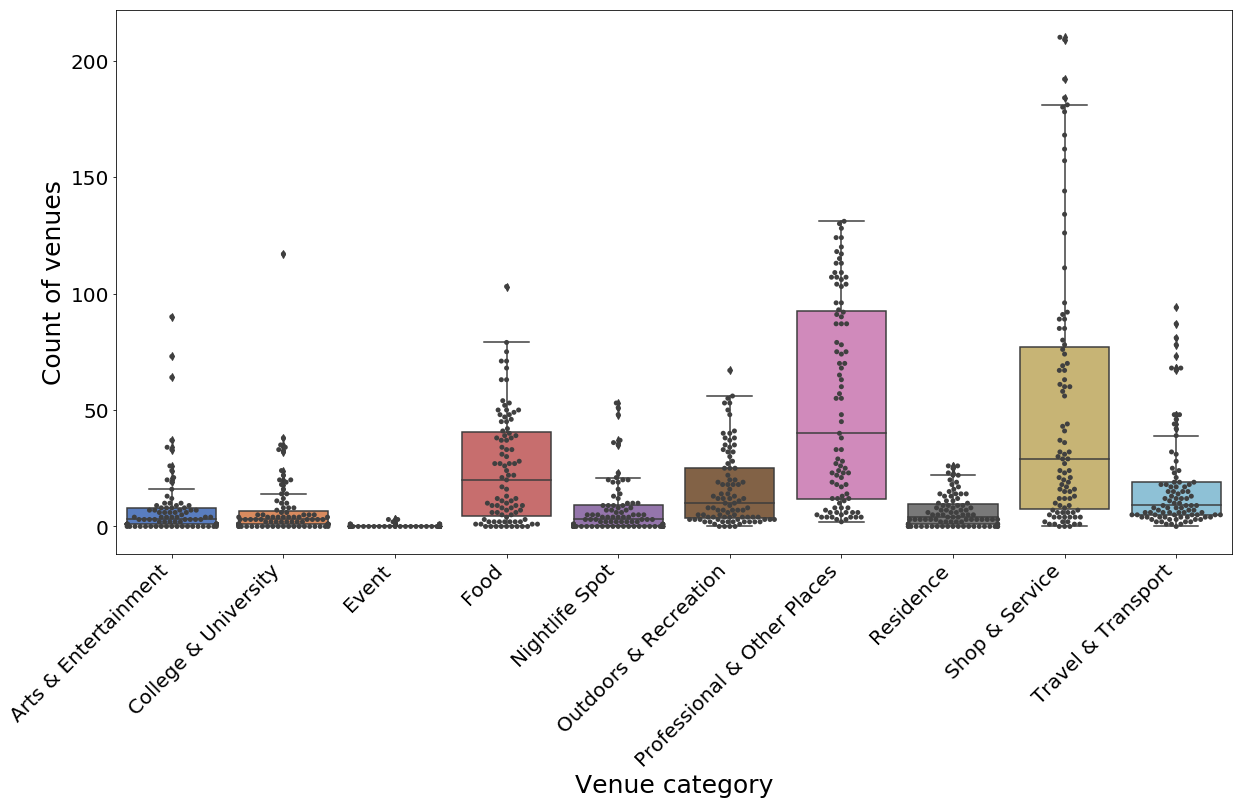

In [47]:
#Make a boxplot
plt.figure(figsize=(20, 10))
plt.xticks(rotation='vertical')
sns.boxplot()
sns.set_palette("muted")

ax = sns.boxplot(data = dc_venue_count.drop(['Lat', 'Lon'], axis = 1))
ax.set_ylabel('Count of venues', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)

#Overlay boxplot with a swarm plot to see if we can understand the data further
ax = sns.swarmplot(data = dc_venue_count.drop(['Lat', 'Lon'], axis = 1), color=".25")
plt.xticks(rotation=45, ha='right')

plt.show()

Looking at the above box plot, overlayed with a swam plot, it is clear that most metro stations have a lower count of venues, however, the few metro stations in highly dense areas skew the mean. 

The right skew makes for longer right tails on the plots indicating that there is greater variance in the stations with more venues than the median, however, the bulk of stations falls on the lower end of venue counts.  

Additionally, we can see that shops, professional, and food venues have the highest count in the area surrounding metro stations in the D.C., Virginia and Maryland area. 


### Normalize data to prepare for clustering

In [48]:
#Import minMax Scaler over Standard Scaler to retain the shape of the data set. 
from sklearn.preprocessing import MinMaxScaler
dc_venue_count.drop(['Event'], axis = 1, inplace = True)
cluster_ds = MinMaxScaler().fit_transform(dc_venue_count.drop(['Station', 'Lat', "Lon"], axis = 1))

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [49]:
cluster_pd = pd.DataFrame(cluster_ds, columns = dc_venue_count.drop(['Station', 'Lat', "Lon"], axis = 1).columns )

#Ensure accuracy 
cluster_pd.head()

,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,0.366667,0.188034,0.359223,0.679245,0.791045,0.790698,0.230769,0.847619,0.829787
1,0.000000,0.273504,0.485437,0.000000,0.820896,0.829457,0.192308,0.914286,0.861702
2,0.222222,0.170940,0.000000,1.000000,0.791045,0.976744,1.000000,0.876190,0.712766
3,0.033333,0.025641,0.320388,0.169811,0.208955,0.209302,0.538462,0.114286,0.180851
4,0.044444,0.008547,0.213592,0.075472,0.104478,0.124031,0.423077,0.142857,0.127660


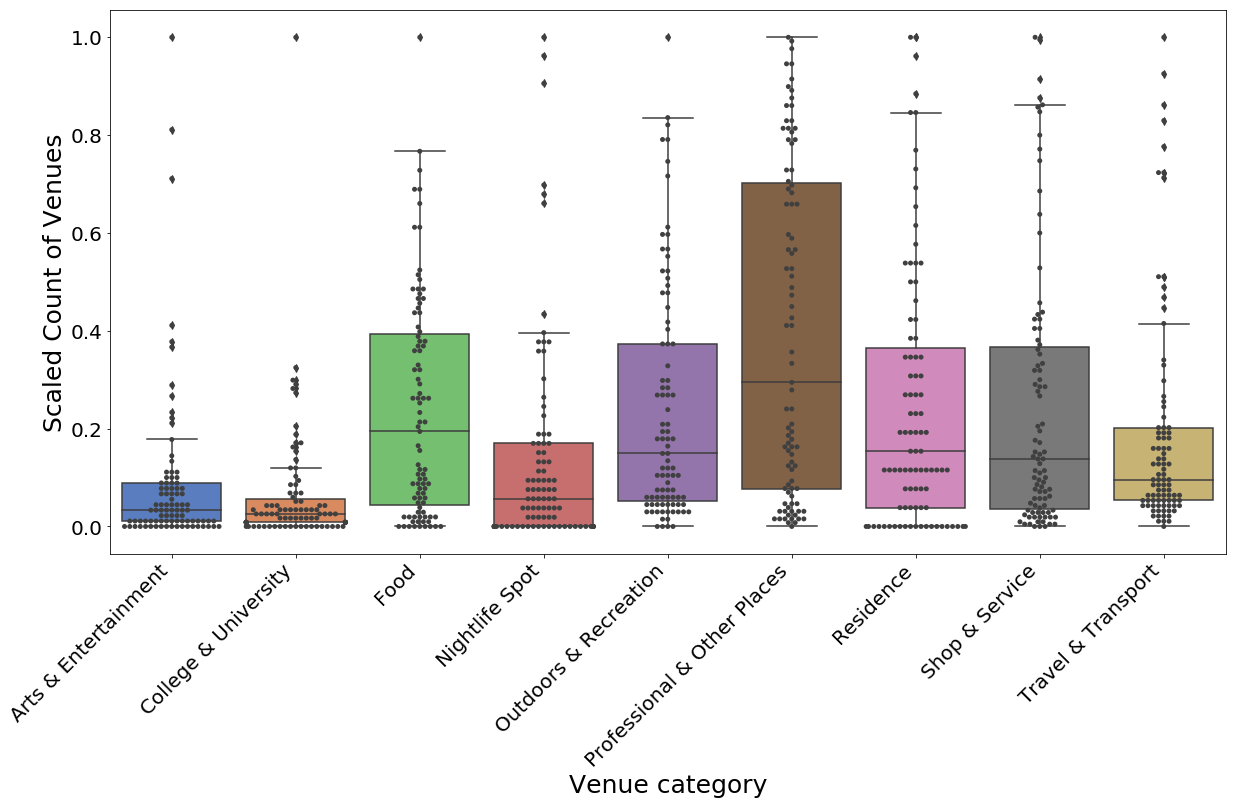

In [52]:
#Make a boxplot to see how normalization might have effected the data
plt.figure(figsize=(20, 10))
plt.xticks(rotation='vertical')
sns.boxplot()
sns.set_palette("muted")

ax = sns.boxplot(data = cluster_pd)
ax.set_ylabel('Scaled Count of Venues', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)

ax = sns.swarmplot(data = cluster_pd, color=".25")

plt.xticks(rotation=45, ha='right')

plt.show()

The normalized data appears to have retained its shape. 

### Clustering
For the clustering analysis we will be using the K-Means model. Let's examine how different values for K change the way the data is clustered. 

In [54]:
from sklearn.cluster import KMeans 

clusterNum = 2
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12, random_state=10)
k_means.fit(cluster_pd)
labels = k_means.labels_

In [56]:
clustered_df = dc_metro_df.copy()
clustered_df['Cluster'] = labels
clustered_df.tail()

,Station,Lat,Lon,Cluster
86,McLean,38.924478,-77.210167,0
87,Tysons Corner,38.920056,-77.223314,1
88,Greensboro,38.919749,-77.235192,0
89,Spring Hill,38.929273,-77.241988,0
90,Wiehle-Reston East,38.947753,-77.340179,0


In [62]:
address = 'Washington D.C., USA'

geolocator = Nominatim(user_agent="usa_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of New York using latitude and longitude values
map_dc = folium.Map(location=[latitude, longitude], width = "50%", height = "50%", zoom_start=11)

# add markers to map
for lat, lng, station, cluster in zip(clustered_df['Lat'], clustered_df['Lon'], clustered_df['Station'], clustered_df['Cluster']):
    colors=['blue','yellow']
    label = '{}'.format(station)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3.5,
        popup=label,
        color=colors[cluster],
        fill=True,
        fill_color=colors[cluster],
        fill_opacity=0.7,
        parse_html=False).add_to(map_dc)  
    
map_dc

The model using two clusters appears to delineate the downtown areas that have a high density in venues from the more suburban areas with a lower density in venues. 

In [96]:
#Let's try three clusters
clusterNum = 3
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12, random_state = 7)
k_means.fit(cluster_pd)
labels = k_means.labels_
print(labels)

[1 1 1 0 0 0 0 2 2 0 0 2 2 2 0 1 2 1 0 0 0 0 2 0 2 0 2 1 1 2 2 0 0 2 2 0 0
 2 0 0 1 2 2 2 2 2 0 0 0 0 0 0 0 2 2 1 2 0 0 0 0 0 1 0 2 0 0 0 0 0 0 0 0 0
 0 0 0 0 2 2 2 2 0 0 0 0 0 2 0 2 0]


In [97]:
clustered_df3 = dc_metro_df.copy()
clustered_df3['Cluster'] = labels
clustered_df3.head()

,Station,Lat,Lon,Cluster
0,Metro Center,38.898303,-77.028099,1
1,Farragut North,38.903192,-77.039766,1
2,Dupont Circle,38.909499,-77.043620,1
3,Woodley Park-Zoo/Adams Morgan,38.924999,-77.052648,0
4,Cleveland Park,38.934703,-77.058226,0


In [98]:
# create map of New York using latitude and longitude values
map_dc = folium.Map(location=[latitude, longitude], width = "50%", height = "50%", zoom_start=11)

# add markers to map
for lat, lng, station, cluster in zip(clustered_df3['Lat'], clustered_df3['Lon'], clustered_df3['Station'], clustered_df3['Cluster']):
    colors=['blue','yellow', 'red']
    label = '{}'.format(station)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3.5,
        popup=label,
        color=colors[cluster],
        fill=True,
        fill_color=colors[cluster],
        fill_opacity=0.7,
        parse_html=False).add_to(map_dc)  
    
map_dc

With three clusters the previous deliniation is further refined. The yellow cluster is exclusively downtown, highly trafficked, business heavy areas. The blue metro stops are have more businesses and are highly trafficked, just not the the extend of the yellows. The red clustering is again the less dense, more suburban areas. 

In [117]:
#Let's try four clusters
clusterNum = 4
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12, random_state=6)
k_means.fit(cluster_pd)
labels = k_means.labels_
print(labels)

[1 1 1 3 0 3 3 3 2 3 0 3 3 3 0 1 2 1 0 0 0 0 2 0 3 0 3 1 1 2 2 0 0 2 2 3 0
 3 0 0 1 3 3 3 3 3 0 0 0 0 0 0 0 2 3 1 2 3 0 3 0 0 1 0 2 0 0 0 0 0 0 0 0 0
 0 0 0 0 2 2 2 2 0 0 0 0 0 3 3 3 3]


In [118]:
clustered_df4 = dc_metro_df.copy()
clustered_df4['Cluster'] = labels
clustered_df4.head()

,Station,Lat,Lon,Cluster
0,Metro Center,38.898303,-77.028099,1
1,Farragut North,38.903192,-77.039766,1
2,Dupont Circle,38.909499,-77.043620,1
3,Woodley Park-Zoo/Adams Morgan,38.924999,-77.052648,3
4,Cleveland Park,38.934703,-77.058226,0


In [119]:
# create map of New York using latitude and longitude values
map_dc = folium.Map(location=[latitude, longitude], width = "50%", height = "50%", zoom_start=11)

# add markers to map
for lat, lng, station, cluster in zip(clustered_df4['Lat'], clustered_df4['Lon'], clustered_df4['Station'], clustered_df4['Cluster']):
    colors=['blue','yellow', 'red', 'purple']
    label = '{}'.format(station)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3.5,
        popup=label,
        color=colors[cluster],
        fill=True,
        fill_color=colors[cluster],
        fill_opacity=0.7,
        parse_html=False).add_to(map_dc)  
    
map_dc

In [120]:
#Combine the two dataframes to have all the necessary info in one table
result = pd.concat([clustered_df4, cluster_pd], axis=1)
result.head()

,Station,Lat,Lon,Cluster,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Metro Center,38.898303,-77.028099,1,0.366667,0.188034,0.359223,0.679245,0.791045,0.790698,0.230769,0.847619,0.829787
1,Farragut North,38.903192,-77.039766,1,0.000000,0.273504,0.485437,0.000000,0.820896,0.829457,0.192308,0.914286,0.861702
2,Dupont Circle,38.909499,-77.043620,1,0.222222,0.170940,0.000000,1.000000,0.791045,0.976744,1.000000,0.876190,0.712766
3,Woodley Park-Zoo/Adams Morgan,38.924999,-77.052648,3,0.033333,0.025641,0.320388,0.169811,0.208955,0.209302,0.538462,0.114286,0.180851
4,Cleveland Park,38.934703,-77.058226,0,0.044444,0.008547,0.213592,0.075472,0.104478,0.124031,0.423077,0.142857,0.127660


Four clusters appears to give the most information before becoming convoluted. Let's examine how the clusters are shaped in a box plot

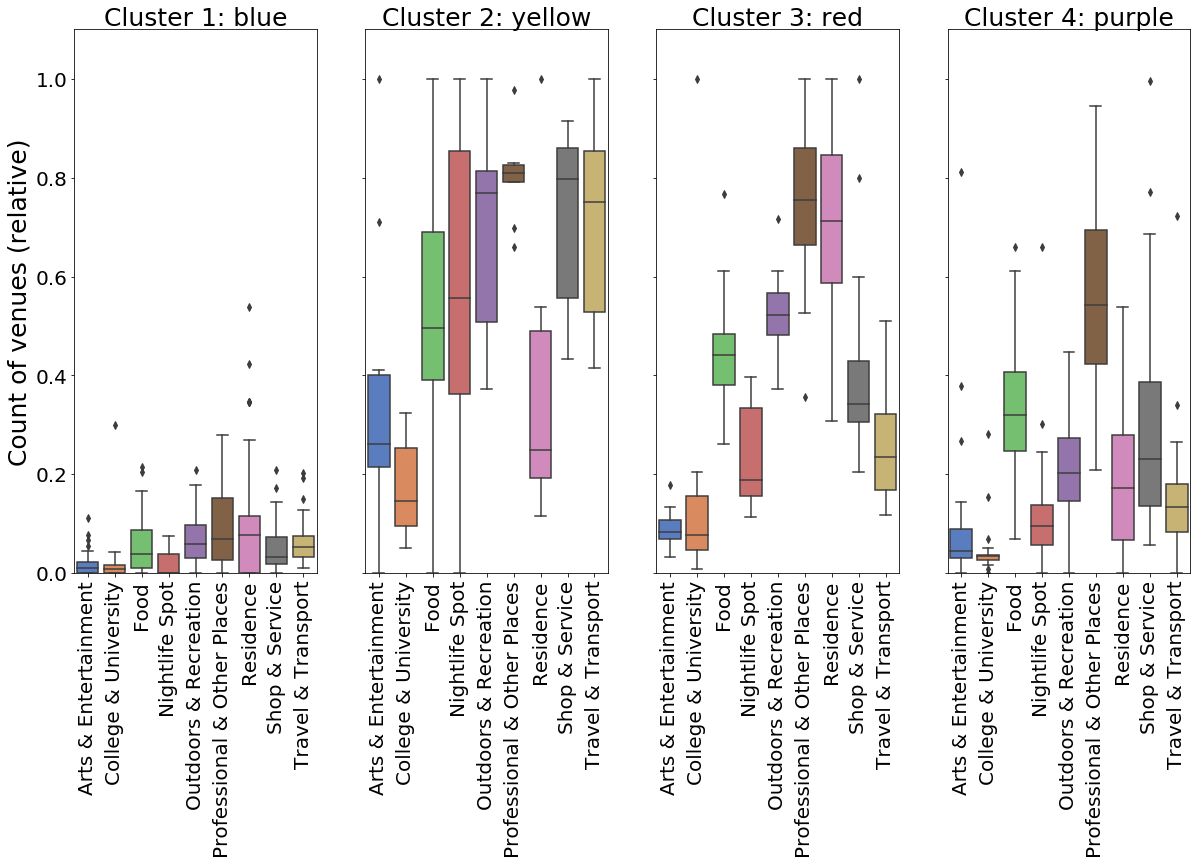

In [121]:
%matplotlib inline
import matplotlib.ticker as ticker

fig, axes = plt.subplots(1,clusterNum, figsize=(20, 10), sharey=True)

axes[0].set_ylabel('Count of venues (relative)', fontsize=25)

for k in range(clusterNum):
    sns.set_palette("muted")
    plt.xticks(rotation='vertical')
    
    axes[k].set_ylim(0,1.1)
    axes[k].xaxis.set_label_position('top')
    axes[k].set_xlabel('Cluster ' + str(k + 1) + ": " + colors[k], fontsize=25)
    axes[k].tick_params(labelsize=20)
    axes[k].xaxis
    plt.sca(axes[k])
    sns.boxplot(data = result[result['Cluster'] == k].drop(['Cluster', 'Lat', 'Lon'], axis=1), ax=axes[k])


plt.show()


In [122]:
#Lets look at the most common venue category types for each station using normalized data
def return_most_common_venues(row, num_venues):
    row_categories = row.iloc[4:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [125]:
num_top_venues = 5

indicators = ['First', 'Second', 'Third', 'Fourth', 'Fifth']

# create columns according to number of top venues
column = ['Station', 'Lat', 'Lon', 'Cluster']
for num in np.arange(num_top_venues):
    column.append('{} Most Common Venue'.format(indicators[num]))

# create a new dataframe
sorted_df= pd.DataFrame(columns=column)
sorted_df['Station'] = result['Station']
sorted_df['Lat'] = result['Lat']
sorted_df['Lon'] = result['Lon']
sorted_df['Cluster'] = result['Cluster']

for cell in np.arange(sorted_df.shape[0]) :
    sorted_df.iloc[cell, 4:]= return_most_common_venues(result.iloc[cell, :], num_top_venues)

sorted_df['Cluster'] = sorted_df['Cluster'] + 1
sorted_df.sort_values(['Cluster'], ascending = False).head()

,Station,Lat,Lon,Cluster,First Most Common Venue,Second Most Common Venue,Third Most Common Venue,Fourth Most Common Venue,Fifth Most Common Venue
45,Eastern Market,38.884124,-76.995334,4,Professional & Other Places,Food,Shop & Service,Outdoors & Recreation,Nightlife Spot
24,Wheaton,39.038558,-77.051098,4,Shop & Service,Food,Professional & Other Places,Residence,Outdoors & Recreation
89,Spring Hill,38.929273,-77.241988,4,Professional & Other Places,Food,Outdoors & Recreation,Residence,Shop & Service
88,Greensboro,38.919749,-77.235192,4,Professional & Other Places,Shop & Service,Food,Residence,Outdoors & Recreation
87,Tysons Corner,38.920056,-77.223314,4,Shop & Service,Professional & Other Places,Food,Nightlife Spot,Outdoors & Recreation


## V. Results & Discussion

        Through an examination of the above maps and plots, a clearer understanding of the clusters characteristics arises. Cluster 1, the blue dots, signify regions with few venues surrounding the station. These neighborhoods are less densely populated, with the main demand for the station being residential areas and professional areas. Cluster 1 stations serve the suburban neighborhoods in the D.C. and surrounding areas. Cluster 2, the yellow dots, lie right in the heart of downtown D.C., thus understandably has the highest relative counts of nightlife, recreation, and food. In fact, cluster 2 has high relative counts for all venue categories except for residential areas. This hints at the fact that there is a demand from these stations to more residential neighborhoods. Cluster 3, the red dots, have a high concentration of professional venues, but what characterizes this cluster appears to be the even higher concentration of residential venues. The vast majority of the red dots are located just outside of D.C. This explains the higher density of residential areas, because the area just outside of D.C. is more affordable and there is more space. Due to this, it would make sense that cluster 2 and cluster 3 be efficiently connected because of demand. Those living in cluster 3 commute to cluster 2 for various venues, but return to cluster 3 for their apartments and homes.  The final cluster, cluster 4, the purple dots, characterize an in between. These neighborhoods are not as spread out as cluster 1, but they are not as densely packed with venues as the other clusters. Shops and services appear to be the main common venues for this final cluster. 
                Based on this initial examination of the WMATA metro stations, we can begin to understand demand to and from stations. The D.C. metro is actively expanding, thus understanding what the common venues surrounding each station are can allow for efficient expansion that benefits the most people. If a hypothetical new station were to be built, it could be added to the data to determine what cluster it falls into, and thus what the demand to and from that station is. I propose an additional analysis, involving comparing the D.C. metro to some of the largest, most efficient rapid transit systems around the world, such as: Hong Kong, New York, and the London Underground. Ideally, there would be a second clustering where similar cities with efficient metro systems are grouped together. Then the WMATA can use the similar cities as examples for expansion. Seeing how other, larger cities expanded can aid the WMATA in refining the current D.C. system as population grows. 


## VI. Conclusion

        The purpose of this project is to examine the primary usage of the metro stations in the DMV area in order to understand the demand to and from each station. This was accomplished using Foursquare API, which admittedly is limited in the amount of data given, as well as KMeans clustering, to classify similar stations. 
        This information is the beginning step in helping the WMATA determine the next best steps for growth. However, this is simply a starting point for city planners. This analysis allows for those working on expansion to more fully understand what they are working with and what they might need in terms of new stations or new lines. Further data and models must be used to continue to answer the question of how the metro system can expand most efficiently, meeting the demands of the citizens. 
